In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/admm-lqr/Project.toml`


In [2]:
Pkg.add("Printf")
using LinearAlgebra
using PyPlot
using Printf

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General`


   Resolving package versions...


  No Changes to `~/SSD/Code/Julia/tinympc-julia/admm-lqr/Project.toml`
  No Changes to `~/SSD/Code/Julia/tinympc-julia/admm-lqr/Manifest.toml`


In [3]:
#2D Double-integrator dynamics
h = 0.1 #20 Hz
A = [I(2) h*I(2); zeros(2,2) I(2)]
B = [0.5*h*h*I(2); h*I(2)];

In [4]:
#Reference state trajectory to track (origin)
t = 0:h:10
N = length(t)
xref = zeros(4,N)
for k = 1:N
  # xref[1:4,k] .= [2.0;5;0;0]  #TODO: can it track all states?
  # xref[1:4,k] .= [k/40;-k/40;1/40/h;-1/40/h]
  # xref[1:4,k] .= [sin(k/40);cos(-k/40);1/40/h;-1/40/h]
end
#Reference input trajectory
uref = zeros(2,N-1);

In [5]:
#Cost Function
# J = Σ 0.5*(x-xref)'*Q*(x-xref) + 0.5*(u-uref)*R*(u-uref) + 0.5*xn'*Qn*xn
Qn = 10.0*I(4)
Q = 10.0*I(4)
# Q = [1 0 0 0; 0 1 0 0; 0 0 0.1 0; 0 0 0 0.1]
R = 0.1*I(2)

q = zeros(4,N)
r = zeros(2,N-1)

function cost(x,u)
    J = 0.0
    for k = 1:(N-1)
        J += 0.5*(x[:,k]-xref[:,k])'*Q*(x[:,k]-xref[:,k]) + 0.5*(u[:,k]-uref[:,k])'*R*(u[:,k]-uref[:,k])
    end
    J += 0.5*(x[:,N]-xref[:,N])'*Qn*(x[:,N]-xref[:,N])
    return J
end

cost (generic function with 1 method)

In [6]:
#ADMM Functions
function backward_pass!(A,B,Q,q,R,r,P,p,K,d)
    #This is the standard Riccati backward pass with both linear and quadratic terms (like iLQR)
    for k = (N-1):-1:1
        q[:,k] .= -Q*xref[:,k]
        r[:,k] .= -R*uref[:,k]
        K[:,:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
        d[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + r[:,k])
        P[:,:,k] .= Q + 1*K[:,:,k]'*R*K[:,:,k] + (A-1*B*K[:,:,k])'*P[:,:,k+1]*(A-B*K[:,:,k])
        p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*(p[:,k+1]-P[:,:,k+1]*B*d[:,k]) + K[:,:,k]'*(R*d[:,k]-r[:,k])
    end
end

function backward_pass_grad!(A,B,q,R,r,P,p,K,d)
    #This is just the linear/gradient term from the backward pass (no cost-to-go Hessian or K calculations)
    for k = (N-1):-1:1
        d[:,k] .= Quu_inv*(B'*p[:,k+1] + r[:,k])
        p[:,k] .= q[:,k] + AmBKt*(p[:,k+1]-Pinf*B*d[:,k]) + Kinf'*(R*d[:,k]-r[:,k])
    end
end

# function backward_pass_grad!(A,B,q,R,r,P,p,K,m)
#     #This is just the linear/gradient term from the backward pass (no cost-to-go Hessian or K calculations)
#     for k = (N-1):-1:1
#         d[:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*p[:,k+1] + r[:,k])
#         p[:,k] .= q[:,k] + (A-B*K[:,:,k])'*(p[:,k+1]-P[:,:,k+1]*B*d[:,k]) + K[:,:,k]'*(R*d[:,k]-r[:,k])
#     end
# end

# function forward_pass!(A,B,K,d,x,u)
#     for k = 1:(N-1)
#         u[:,k] .= -K[:,:,k]*(x[:,k] - 0*xref[:,k]) - d[:,k] 
#         x[:,k+1] .= A*x[:,k] + B*u[:,k]
#     end
# end

function forward_pass!(A,B,K,d,x,u)
    for k = 1:(N-1)
        u[:,k] .= -Kinf*(x[:,k]) - d[:,k] 
        x[:,k+1] .= A*x[:,k] + B*u[:,k]
    end
end

function update_primal!(A,B,q,R̃,r,P,p,K,d,x,u)
    backward_pass_grad!(A,B,q,R̃,r,P,p,K,d)
    forward_pass!(A,B,K,d,x,u)
end
function update_slack!(u,z,y)
    #This function clamps the controls to be within the bounds
    for k = 1:(N-1)
        z[:,k] .= min.(umax, max.(umin, u[:,k]+y[:,k]))
    end
end

function update_dual!(u,z,y)
    #This function performs the standard AL multiplier update.
    #Note that we're using the "scaled form" where y = λ/ρ
    for k = 1:(N-1)
        y[:,k] .= y[:,k] + u[:,k] - z[:,k]
    end
end

function update_linear_cost!(z,y,r)
    #This function updates the linear term in the control cost to handle the changing cost term from ADMM
    for k = 1:(N-1)
        r[:,k] .= -ρ*(z[:,k]-y[:,k]) - R*uref[:,k] #TODO: check if R vs. R̃ matters
        q[:,k] .= -Q*xref[:,k]
    end
    q[:,N] .= -Pinf*xref[:,N]
end

update_linear_cost! (generic function with 1 method)

In [7]:
#Control Bounds
umin = -[1.0; 1.0]*1
umax = [1.0; 1.0]*1;

In [8]:
#Algorithm Setup

x = zeros(4,N)
# x[:,1] .= [5.0; 7; 2; -1.4]
x[:,1] .= [1.0; 0; 0; 1.0]
u = zeros(2,N-1)

ρ = 5
R̃ = R + 1*ρ*I

P = zeros(4,4,200)
P[:,:,200] .= Q
K = zeros(2,4,200-1)

for k = (200-1):-1:1
  K[:,:,k] .= (R̃ + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
  P[:,:,k] .= Q + A'*P[:,:,k+1]*(A - B*K[:,:,k])
end

Pinf = 1*P[:,:,1]
Kinf = 1*K[:,:,1]
Quu_inv = (R̃ + B'*Pinf*B)\I
AmBKt = (A-B*Kinf)'
coeff_d2p = Kinf'*R̃ - AmBKt*Pinf*B

P = zeros(4,4,N)
P[:,:,N] .= Pinf
p = zeros(4,N)
p[:,N] .= -Pinf*xref[:,N]  #q[:,N]

K = zeros(2,4,N-1)
d = zeros(2,N-1)

z = zeros(2,N-1);
znew = zeros(2,N-1);
y = zeros(2,N-1);

# update_linear_cost!(z,y,r)
# backward_pass_grad!(A,B,q,R̃,r,P,p,K,d)

2×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [22]:
function export_mat_to_c(declare, data)
  str = "sfloat " * declare * " = {\n"
  dataT = data'
  for i = 1:size(dataT, 1)
      str = str * "  "
      for j = 1:size(dataT, 2)
          this_str = @sprintf("%.6f", dataT[i, j])
          str = str * this_str * "f,"
      end
      str = str * "\n"
  end
  str = str * "};"
  return str
end

@printf("%s\n",export_mat_to_c("Kinf_data[NINPUTS*NSTATES]", Kinf))
@printf("%s\n",export_mat_to_c("Pinf_data[NSTATES*NSTATES]", Pinf))
@printf("%s\n",export_mat_to_c("Quu_inv_data[NINPUTS*NINPUTS]", Quu_inv))
@printf("%s\n",export_mat_to_c("AmBKt_data[NSTATES*NSTATES]", AmBKt))
@printf("%s\n",export_mat_to_c("coeff_d2p_data[NSTATES*NINPUTS]", coeff_d2p))

sfloat Kinf_data[NINPUTS*NSTATES] = {
  1.255647f,0.000000f,
  0.000000f,1.255647f,
  2.021867f,0.000000f,
  0.000000f,2.021867f,
};
sfloat Pinf_data[NSTATES*NSTATES] = {
  161.021861f,0.000000f,71.589105f,0.000000f,
  0.000000f,161.021861f,0.000000f,71.589105f,
  71.589105f,0.000000f,116.694654f,0.000000f,
  0.000000f,71.589105f,0.000000f,116.694654f,
};
sfloat Quu_inv_data[NINPUTS*NINPUTS] = {
  0.157665f,0.000000f,
  0.000000f,0.157665f,
};
sfloat AmBKt_data[NSTATES*NSTATES] = {
  0.993722f,0.000000f,0.089891f,0.000000f,
  0.000000f,0.993722f,0.000000f,0.089891f,
  -0.125565f,0.000000f,0.797813f,0.000000f,
  0.000000f,-0.125565f,0.000000f,0.797813f,
};


sfloat coeff_d2p_data[NSTATES*NINPUTS] = {
  0.000000f,0.000000f,-0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,-0.000000f,
};


In [10]:
#Main algorithm loop

# update_primal!(A,B,q,R̃,r,P,p,K,d,x,u)
# update_slack!(u,znew,y)
# update_dual!(u,znew,y)
# update_linear_cost!(znew,y,r)

iter = 0
primal_residual = 1.0
dual_residual = 1.0
for k = 1:100
    update_primal!(A,B,q,R̃,r,P,p,K,d,x,u)
    update_slack!(u,znew,y)
    update_dual!(u,znew,y)
    update_linear_cost!(znew,y,r)
    
    # @show z[:,2]
    # @show u[:,2]
    # @show y[:,2]
    # @show abs.(u-znew)
    primal_residual = maximum(abs.(u-znew))
    dual_residual = maximum(abs.(ρ*(znew-z)))
    if (primal_residual < 0.01 && dual_residual < 0.01)
        break
    end

    z .= znew
    iter += 1
end

In [11]:
z

2×100 Matrix{Float64}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -0.683165  …  0.000140693  0.000214473
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0          0.000159574  0.00024217

In [12]:
@show iter
@show primal_residual
@show dual_residual

iter = 58
primal_residual = 9.60818047142098e-5
dual_residual = 0.009984838381097427


0.009984838381097427

In [13]:
# Kinf = zeros(nu, nx)
# P = 1*Q
# for ricatti_iter = 1:100
#     Kinf = (R + B' * P * B) \ (B' * P * A)
#     P = Q + A' * P * (A - B * Kinf)
# end    
# # TODO: simulate this controlled system with rk4(params_real, ...)
# for k = 1:(N-1)
#     u[:,k] .= -0.01*Kinf*(x[:,k]-1*xref[:,k]) 
#     x[:,k+1] .= A*x[:,k] + B*u[:,k]
# end

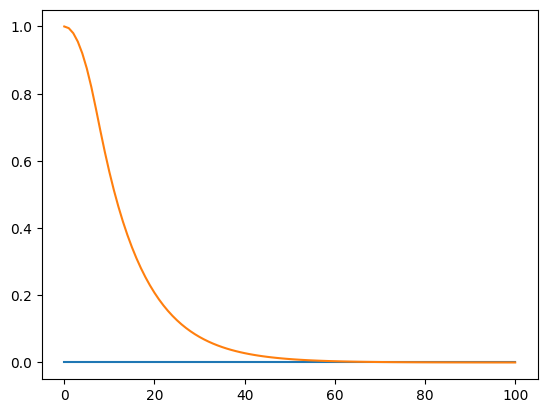

In [14]:
fig = plt.figure()
plot(xref[1,:])
plot(x[1,:]+0*xref[1,:])
fig

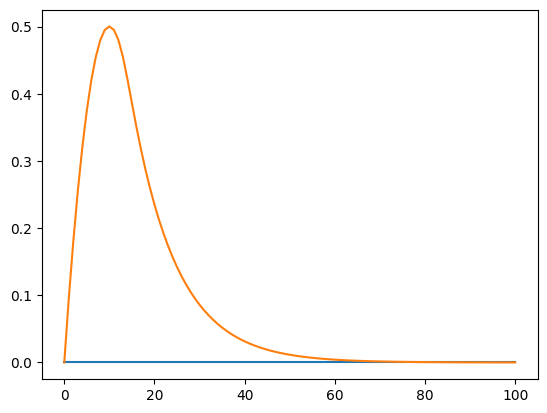

In [15]:
fig = plt.figure()
plot(xref[2,:])
plot(x[2,:]+0*xref[2,:])
fig

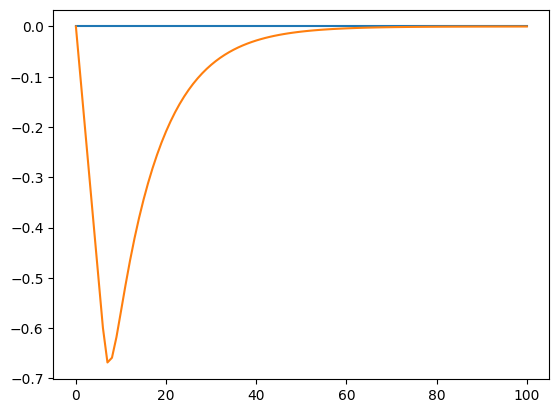

In [16]:
fig = plt.figure()
plot(xref[3,:])
plot(x[3,:]+0*xref[3,:])
fig

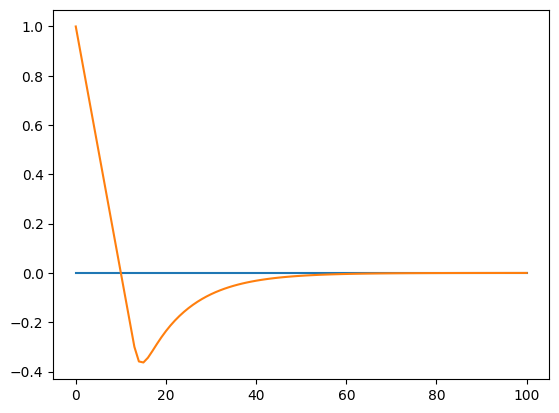

In [17]:
fig = plt.figure()
plot(xref[4,:])
plot(x[4,:]+0*xref[4,:])
fig

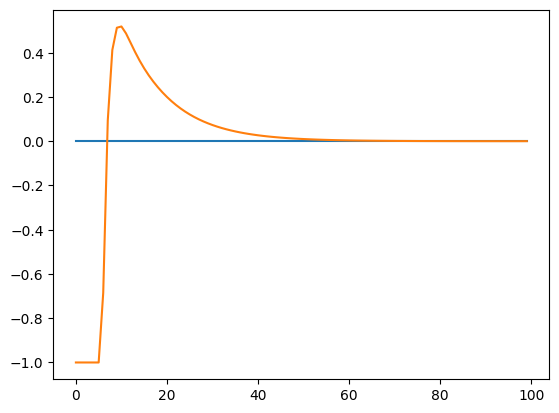

In [18]:
fig = plt.figure()
plot(uref[1,:])
plot(u[1,:])
fig

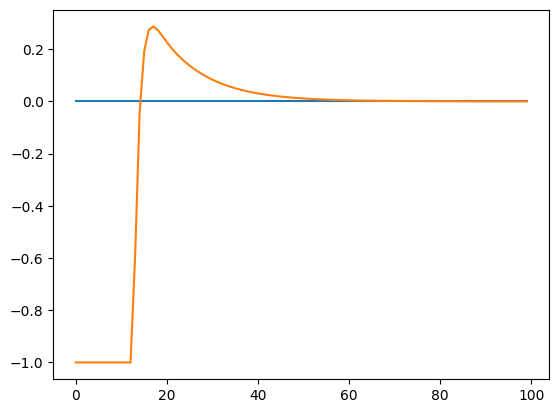

In [19]:
fig = plt.figure()
plot(uref[2,:])
plot(u[2,:])
fig

In [20]:
plot(y[1,:])
plot(y[2,:])

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7efcb4feb5d0>

In [21]:
plot(z[1,:])
plot(z[2,:])

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7efcb509d610>